<a href="https://colab.research.google.com/github/Aditya-Patel/Stat598-FinalProject/blob/main/MPLA_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
# Dataset
import yfinance as yf

# Visualization
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 5)

# Date Manipulation
from datetime import datetime

# PyTorch Libraries
import tensorflow as tf
from tensorflow import keras

# statstical testing, plotting and decompositions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Set device usage to GPU if available
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
device = tf.device('/device:gpu:1')

In [94]:
# Neural Network Constants
TRAINING_EPOCHS = 2000
BATCH_SIZE = 16
NEURON_CT = 128
POOL_SZ = 3
STRIDES = 1

In [95]:
start_date = '2020-06-01'
end_date = '2023-12-01'
etf_ticker = 'MLPA'
moving_average_list = []
etf_tickers_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/mlpa_full-holdings.csv"
crude_oil_stock_url = "https://raw.githubusercontent.com/Aditya-Patel/Stat598-FinalProject/main/crude%20oil%20spot%20price.csv"

<h1>Create joint dataset between spot price and ETF Data</h1>

In [96]:
df_holdings = pd.read_csv(etf_tickers_url)
df_holdings = df_holdings[(df_holdings['Name'] != 'OTHER PAYABLE & RECEIVABLES') & (df_holdings['Name'] != 'CASH')]
df_holdings[f'Market Value ($)'] = df_holdings[f'Market Value ($)'].str.replace(',', '').astype(float)
total_market_value = df_holdings[f'Market Value ($)'].sum()
df_holdings['Percentage Holdings By Value'] = (df_holdings[f'Market Value ($)'] / total_market_value)

df_crude_price = pd.read_csv(crude_oil_stock_url,usecols=[0, 1])
df_crude_price['Date'] = pd.to_datetime(df_crude_price['Date'], format='%b %d, %Y')
df_crude_price.set_index('Date', inplace=True)
df_crude_price.rename(columns={'WTI Barrell Spot Price':'Spot Price'}, inplace=True)
df_crude_price['Spot Price'] = df_crude_price['Spot Price'].fillna(method='ffill')

all_stocks_data = yf.download(etf_ticker, start=start_date, end=end_date)

# Join spot price and etf data
all_stocks_data['Ticker'] = etf_ticker
all_stocks_data.columns = [f'{etf_ticker}_{col}' if col not in ['Ticker', 'Date'] else col for col in all_stocks_data.columns]
all_stocks_data = all_stocks_data.join(df_crude_price, how='left')

[*********************100%%**********************]  1 of 1 completed


<h1>Load all tickers within the ETF</h1>

In [97]:
# load all tickers part of that etf
for ticker in df_holdings['Ticker']:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    percentage_holding = df_holdings.loc[df_holdings['Ticker'] == ticker, 'Percentage Holdings By Value'].iloc[0]
    all_stocks_data[f'{ticker}_Percent_Holding'] = percentage_holding
    stock_data.columns = [f'{ticker}_{col}' if col != 'Ticker' else col for col in stock_data.columns]
    all_stocks_data = all_stocks_data.join(stock_data, how='outer')

all_stocks_data.fillna(0, inplace=True)
sum_values = pd.Series(0, index=all_stocks_data.index)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

In [98]:
# Get all closing values

all_stocks_data[f'{etf_ticker}_Next_Close'] = all_stocks_data[f'{etf_ticker}_Close'].shift(-1)
all_stocks_data = all_stocks_data.drop(all_stocks_data.index[-1])
close_values = all_stocks_data[[col for col in all_stocks_data.columns if '_Close' in col or col == 'Spot Price' or col == f'{etf_ticker}_Next_Close']]


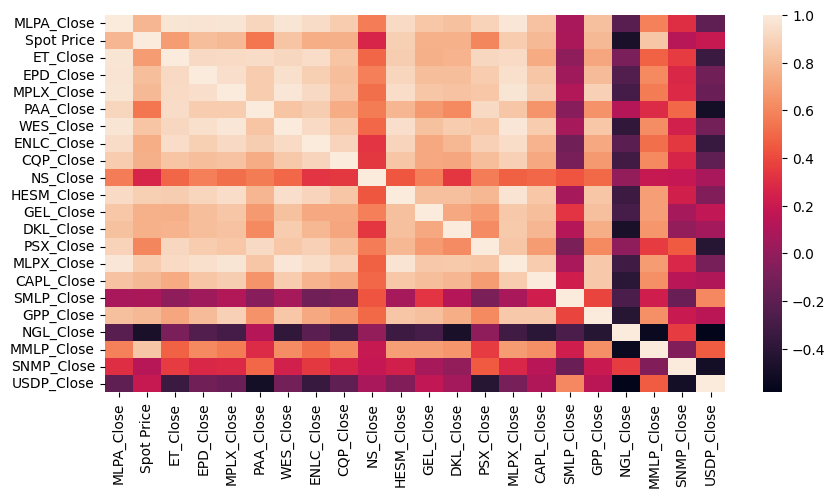

In [99]:
# Check correlation
df = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])
sns.heatmap(df.corr(), annot=False)
plt.show()

Based on the plot of the correlation matrix, we see that most of the stocks are correlated positively with each other with the exception of SMLP, NGL and USDP, which have negative correlation. We expect to see this as a good ETF consists of a variety of tickers to protect against large market swings either way.

<h1>Model Development<h1>
<h2> A Dense Neural Network is developed in TensorFlow to perform future analysis based on the previous closing price trend. <h2>

In [100]:
# Generate X and y input datasets - Since we are predicting the next day value, we use the 'Next_Close' as the target value
y = close_values[f'{etf_ticker}_Next_Close']
X = close_values.drop(columns=[f'{etf_ticker}_Next_Close'])

In [101]:
# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)

# Convert to tensors and prefetch
train_df = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_df = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_df = train_df.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [102]:
# CNN - 3 Convolution Layers, 3 Dense Layers
model_1 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/2, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(1)
])

model_1.compile(optimizer='adam', loss='mean_squared_error')

In [103]:
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 20, 32)            128       
                                                                 
 max_pooling1d_34 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_35 (Conv1D)          (None, 16, 64)            6208      
                                                                 
 max_pooling1d_35 (MaxPooli  (None, 14, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_36 (Conv1D)          (None, 12, 128)           24704     
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 10, 128)         

In [104]:
# CNN 1- 2 Convolution Layers, 4 Dense Layers
model_2 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(NEURON_CT/2, activation='relu'),
    keras.layers.Dense(NEURON_CT/4, activation='relu'),
    keras.layers.Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')

In [105]:
model_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 20, 32)            128       
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 18, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_38 (Conv1D)          (None, 16, 128)           12416     
                                                                 
 max_pooling1d_38 (MaxPooli  (None, 14, 128)           0         
 ng1D)                                                           
                                                                 
 dense_37 (Dense)            (None, 14, 128)           16512     
                                                                 
 dense_38 (Dense)            (None, 14, 64)          

In [106]:
# CNN 1- 4 Convolution Layers, 2 Dense Layers
model_3 = keras.models.Sequential([
    # Convolution Layer
    keras.layers.Conv1D(input_shape=(22,1), filters=NEURON_CT/8, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/4, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT/2, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    keras.layers.Conv1D(filters=NEURON_CT, kernel_size=(3,), activation='relu'),
    keras.layers.MaxPool1D(pool_size=POOL_SZ, strides=STRIDES, padding='valid'),
    # DNN Layer
    keras.layers.Dense(NEURON_CT, activation='relu'),
    keras.layers.Dense(1)
])

model_3.compile(optimizer='adam', loss='mean_squared_error')

In [107]:
model_3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 20, 16)            64        
                                                                 
 max_pooling1d_39 (MaxPooli  (None, 18, 16)            0         
 ng1D)                                                           
                                                                 
 conv1d_40 (Conv1D)          (None, 16, 32)            1568      
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 14, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_41 (Conv1D)          (None, 12, 64)            6208      
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 10, 64)          

In [108]:
# Fit model to training data with 20% validation split
model_1.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.2)


Epoch 1/2000
27/27 [==============================] - 1s 8ms/step - loss: 143.8636 - val_loss: 34.9172
Epoch 2/2000
27/27 [==============================] - 0s 3ms/step - loss: 18.0378 - val_loss: 8.2561
Epoch 3/2000
27/27 [==============================] - 0s 3ms/step - loss: 6.3646 - val_loss: 6.1204
Epoch 4/2000
27/27 [==============================] - 0s 3ms/step - loss: 4.3012 - val_loss: 3.3261
Epoch 5/2000
27/27 [==============================] - 0s 3ms/step - loss: 3.5267 - val_loss: 2.5355
Epoch 6/2000
27/27 [==============================] - 0s 3ms/step - loss: 3.1513 - val_loss: 3.4391
Epoch 7/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.6344 - val_loss: 2.0811
Epoch 8/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.1738 - val_loss: 2.2243
Epoch 9/2000
27/27 [==============================] - 0s 4ms/step - loss: 2.0892 - val_loss: 2.6377
Epoch 10/2000
27/27 [==============================] - 0s 3ms/step - loss: 2.2736 - val_loss: 2.

In [ ]:

model_2.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.2)


Epoch 1/2000
14/14 [==============================] - 0s 10ms/step - loss: 1077.1376 - val_loss: 567.4736
Epoch 2/2000
14/14 [==============================] - 0s 3ms/step - loss: 376.7722 - val_loss: 320.9236
Epoch 3/2000
14/14 [==============================] - 0s 4ms/step - loss: 271.6736 - val_loss: 220.3160
Epoch 4/2000
14/14 [==============================] - 0s 3ms/step - loss: 200.9629 - val_loss: 161.6154
Epoch 5/2000
14/14 [==============================] - 0s 2ms/step - loss: 141.3480 - val_loss: 109.9087
Epoch 6/2000
14/14 [==============================] - 0s 2ms/step - loss: 99.9083 - val_loss: 82.2128
Epoch 7/2000
14/14 [==============================] - 0s 2ms/step - loss: 77.0370 - val_loss: 66.4477
Epoch 8/2000
14/14 [==============================] - 0s 3ms/step - loss: 63.5392 - val_loss: 56.1201
Epoch 9/2000
14/14 [==============================] - 0s 3ms/step - loss: 53.9533 - val_loss: 48.3867
Epoch 10/2000
14/14 [==============================] - 0s 3ms/step - l

In [ ]:

model_3.fit(X_train,
            y_train,
            epochs = TRAINING_EPOCHS,
            batch_size = BATCH_SIZE,
            validation_split = 0.2)

Epoch 1/2000
14/14 [==============================] - 1s 9ms/step - loss: 1087.8660 - val_loss: 250.2032
Epoch 2/2000
14/14 [==============================] - 0s 3ms/step - loss: 131.7709 - val_loss: 43.4969
Epoch 3/2000
14/14 [==============================] - 0s 3ms/step - loss: 60.5303 - val_loss: 36.7399
Epoch 4/2000
14/14 [==============================] - 0s 3ms/step - loss: 37.1482 - val_loss: 27.8345
Epoch 5/2000
14/14 [==============================] - 0s 3ms/step - loss: 27.9353 - val_loss: 22.6956
Epoch 6/2000
14/14 [==============================] - 0s 3ms/step - loss: 22.4758 - val_loss: 19.5256
Epoch 7/2000
14/14 [==============================] - 0s 3ms/step - loss: 18.6620 - val_loss: 16.0347
Epoch 8/2000
14/14 [==============================] - 0s 3ms/step - loss: 15.7830 - val_loss: 13.6104
Epoch 9/2000
14/14 [==============================] - 0s 3ms/step - loss: 13.3693 - val_loss: 11.5115
Epoch 10/2000
14/14 [==============================] - 0s 3ms/step - loss: 11.

In [ ]:
# Predict next close with all models

y1_pred = [val[0] for val in [val[0] for val in model_1.predict(X_test)]]
mse1 = mean_squared_error(y1_pred, y_test)


12/12 [==============================] - 0s 827us/step


In [ ]:

y2_pred = [val[0] for val in [val[0] for val in model_2.predict(X_test)]]
mse2 = mean_squared_error(y2_pred, y_test)


12/12 [==============================] - 0s 750us/step


In [ ]:

y3_pred = [val[0] for val in [val[0] for val in model_3.predict(X_test)]]
mse3 = mean_squared_error(y3_pred, y_test)

12/12 [==============================] - 0s 743us/step


In [ ]:
results_df = pd.DataFrame(y_test)
results_df['y1_pred'] = y1_pred
results_df['y2_pred'] = y2_pred
results_df['y3_pred'] = y3_pred

In [ ]:
results_df.columns = ['y_actual', 'y1_pred', 'y2_pred', 'y3_pred']
results_df.sort_index(inplace=True)
results_df

,y_actual,y1_pred,y2_pred,y3_pred
Date,,,,
2020-06-03,31.940001,32.878235,32.517590,33.390526
2020-06-08,33.180000,36.280567,36.126030,35.948563
2020-06-09,32.689999,34.172718,34.332851,34.318962
2020-06-10,29.230000,33.674522,33.608017,33.686447
2020-06-15,31.299999,33.086620,32.190525,32.599651
...,...,...,...,...
2023-11-16,44.910000,44.745842,44.207001,45.897388
2023-11-21,45.200001,45.516045,45.035934,46.087074
2023-11-22,45.200001,45.683125,45.139805,46.588055


In [ ]:
print(f'Hyperparameters: [Training Epochs: {TRAINING_EPOCHS} || Batch Size: {BATCH_SIZE} || Neurons: {NEURON_CT}]')
print(f'Price forecast: model_1: MSE: {mse1:.4f}')
print(f'Price forecast: model_2: MSE: {mse2:.4f}')
print(f'Price forecast: model_3: MSE: {mse3:.4f}')


Hyperparameters: [Training Epochs: 2000 || Batch Size: 32 || Neurons: 64]
Price forecast: model_1: MSE: 0.8876
Price forecast: model_2: MSE: 0.7993
Price forecast: model_3: MSE: 1.3024


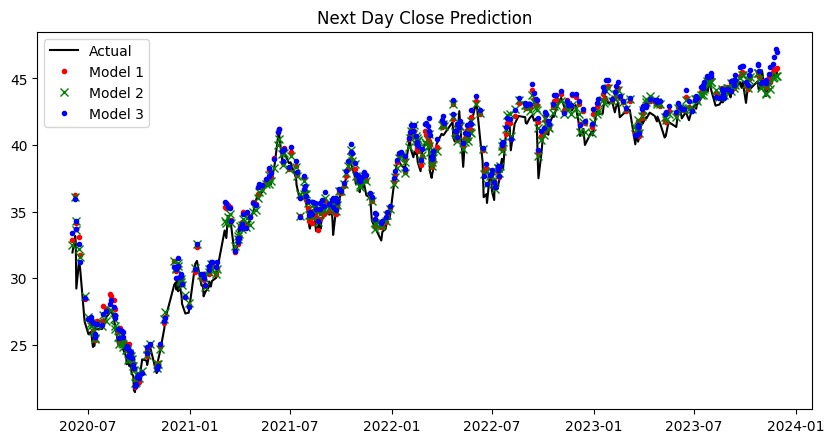

In [ ]:
x = [x for x in range(len(y_test))]
plt.plot(results_df.y_actual, 'k', label='Actual')
plt.plot(results_df.y1_pred, '.r', label='Model 1')
plt.plot(results_df.y2_pred, 'xg', label='Model 2')
plt.plot(results_df.y3_pred, '.b', label='Model 3')
plt.title('Next Day Close Prediction')
plt.legend()
plt.show()

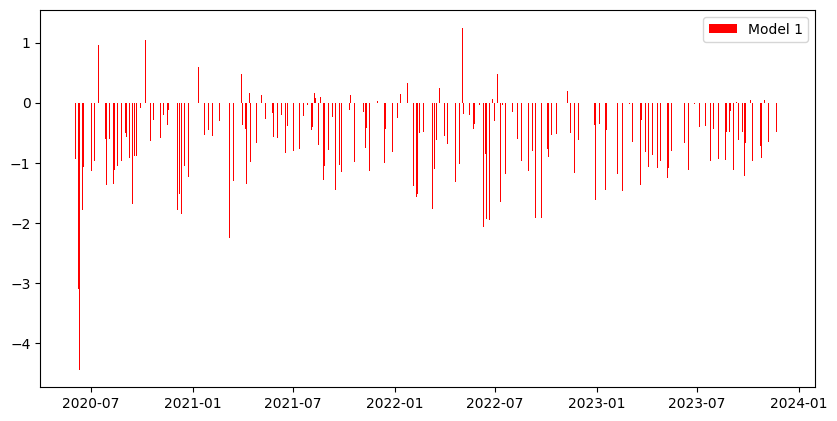

In [ ]:
y1_diff = results_df.y_actual - results_df.y1_pred
y2_diff = results_df.y_actual - results_df.y2_pred
y3_diff = results_df.y_actual - results_df.y3_pred

plt.bar(results_df.index, y1_diff, color='red', label='Model 1')
plt.title('Model 1: Error')
plt.legend()
plt.show()

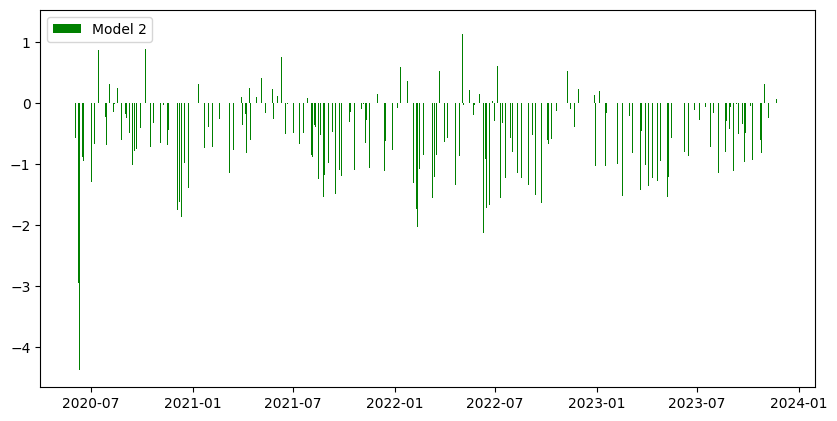

In [ ]:
plt.bar(results_df.index, y2_diff, color='green', label='Model 2')
plt.title('Model 2: Error')
plt.legend()
plt.show()

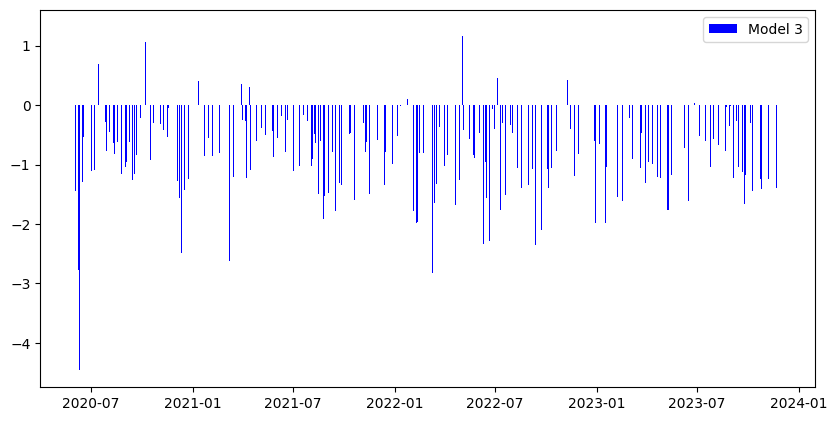

In [ ]:
plt.bar(results_df.index, y3_diff, color='blue', label='Model 3')
plt.title('Model 3: Error')
plt.legend()
plt.show()